   Maturity (years)  Discount Factor  Zero-Coupon Yield (%)
0              0.08           0.9964                 4.3378
1              0.25           0.9893                 4.3132
2              0.50           0.9789                 4.2652
3              1.00           0.9586                 4.2281
4              2.00           0.9186                 4.2450
5              3.00           0.8791                 4.2962
6              5.00           0.8034                 4.3781
7              7.00           0.7313                 4.4713
8             10.00           0.6335                 4.5644
9             30.00           0.2380                 4.7856


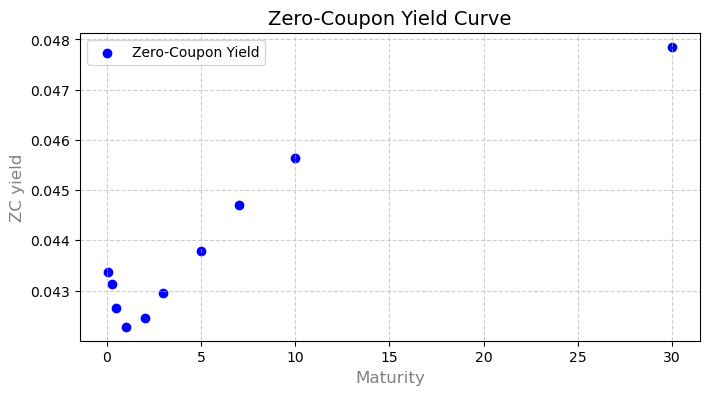

In [1]:
# 1
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import pandas as pd

class ZeroCouponCalculator:
    def __init__(self):
        # Store yields for bills (expressed as percentages)
        self.bills_yields = {
            1/12: 4.33,  # 1-month
            1/4: 4.29,   # 3-month
            1/2: 4.22,   # 6-month
            1.0: 4.14    # 1-year
        }
        
        # Calculate discount factors for bills using yield
        self.bills_discount_factors = {
            t: 1 - y / 100 * t for t, y in self.bills_yields.items()
        }
        
        # Store known rates for bonds
        self.bond_rates = {
            2.0: 4.29,
            3.0: 4.34,
            5.0: 4.42,
            7.0: 4.51,
            10.0: 4.60,
            30.0: 4.82
        }
        
    def get_discount_factor(self, t):
        """
        Get discount factor for time t
        For t <= 1: retrieve from bills_discount_factors
        For 1 < t: interpolate if needed
        """
        if t in self.bills_discount_factors:
            return self.bills_discount_factors[t]
        elif t <= 1:
            # Find surrounding points and interpolate
            times = sorted(self.bills_discount_factors.keys())
            idx = np.searchsorted(times, t)
            t1, t2 = times[idx-1], times[idx]
            d1 = self.bills_discount_factors[t1]
            d2 = self.bills_discount_factors[t2]
            return (d1+d2)/2
        return None

    def calculate_bond_discount_factor(self, T, rate):
        """Calculate discount factor for a bond with maturity T"""
        rate = rate / 100  # Convert to decimal
        
        def bond_price_equation(P):
            price = 0
            # Calculate semi-annual coupon payments
            for i in range(1, int(T * 2) + 1):
                t = i / 2
                if t <= 1:
                    # Use stored bills discount factors
                    df = self.get_discount_factor(t)
                elif t > 1 and t < T:
                    if t.is_integer():
                        if t in self.bond_discount_factors:
                            df = self.bond_discount_factors[t]
                        else:
                            df = P ** (t / T)
                    else:
                        # For non-integer t > 1, use average of surrounding points
                        t_floor = int(t)
                        t_ceil = t_floor + 1
                        if t_floor == 1:
                            df_floor = self.bills_discount_factors[1.0]
                        else:
                            df_floor = self.bond_discount_factors.get(t_floor, P ** (t_floor / T))
                        df_ceil = self.bond_discount_factors.get(t_ceil, P ** (t_ceil / T))
                        df = (df_floor + df_ceil) / 2
                else:  # t = T
                    df = P
                
                price += (rate * 100 / 2) * df
            
            # Add final payment
            price += 100 * P
            return price - 100
        
        # Solve for the discount factor
        initial_guess = 1 / (1 + rate) ** T
        P = fsolve(bond_price_equation, x0=initial_guess)[0]
        return P

    def calculate_all_discount_factors(self):
        """Calculate discount factors for all bonds"""
        self.bond_discount_factors = {}
        
        # Calculate discount factors in order of maturity
        for T in sorted(self.bond_rates.keys()):
            P = self.calculate_bond_discount_factor(T, self.bond_rates[T])
            self.bond_discount_factors[T] = P
            
        return self.bond_discount_factors

    def calculate_zero_coupon_yields(self):
        """Calculate zero-coupon yields for all maturities"""
        # Calculate bond discount factors
        self.calculate_all_discount_factors()
        
        # Combine all discount factors
        all_discount_factors = {**self.bills_discount_factors, **self.bond_discount_factors}
        
        # Calculate zero-coupon yields
        zero_coupon_yields = {}
        for t, df in sorted(all_discount_factors.items()):
            zcy = -1 / t * np.log(df) * 100
            zero_coupon_yields[t] = zcy
        
        return zero_coupon_yields

def main():
    calculator = ZeroCouponCalculator()
    zero_coupon_yields = calculator.calculate_zero_coupon_yields()

    # Prepare data for DataFrame
    data = []
    for t in sorted(zero_coupon_yields.keys()):
        df = calculator.bills_discount_factors.get(t) or calculator.bond_discount_factors.get(t)
        zcy = zero_coupon_yields[t]
        data.append([round(t, 2), round(df, 4), round(zcy, 4)])

    # Create DataFrame
    df_results = pd.DataFrame(data, columns=["Maturity (years)", "Discount Factor", "Zero-Coupon Yield (%)"])

    # Display DataFrame
    print(df_results)

    # Plot scatter chart
    plt.figure(figsize=(8, 4))
    plt.scatter(df_results["Maturity (years)"], df_results["Zero-Coupon Yield (%)"] / 100, color='blue', label="Zero-Coupon Yield")

    # Labels and formatting
    plt.xlabel("Maturity", fontsize=12, color='gray')
    plt.ylabel("ZC yield", fontsize=12, color='gray')
    plt.title("Zero-Coupon Yield Curve", fontsize=14)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    # Display the chart
    plt.show()

# Run the main function
main()


Nelson-Siegel-Svensson Fitting Results:
               Value
β₀          0.045481
β₁         -0.001947
β₂         -0.008202
β₃          0.010121
τ           1.388273
θ          25.012828
Objective    1.4e-07


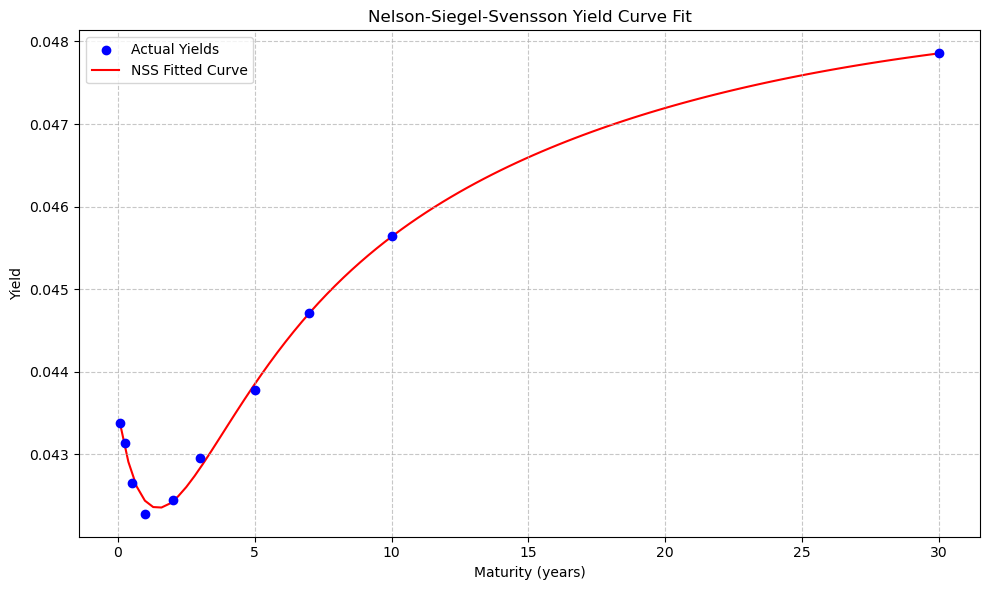

In [2]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def nss_yield(t, params):
    """
    Calculate yield using Nelson-Siegel-Svensson function
    params: [a, b, c, d, tau, theta]
    """
    a, b, c, d, tau, theta = params
    
    # Handle very small t values to avoid division by zero
    if t < 1e-10:
        t = 1e-10
    
    factor1 = (1 - np.exp(-t/tau)) / (t/tau)
    factor2 = factor1 - np.exp(-t/tau)
    factor3 = (1 - np.exp(-t/theta)) / (t/theta) - np.exp(-t/theta)
    
    return a + b*factor1 + c*factor2 + d*factor3

def objective_function(params, maturities, yields, weighted=True):
    """
    Calculate weighted sum of squared errors between actual and fitted yields
    With special weighting for short-end (1/t) and long-end (t) of the curve
    """
    fitted_yields = np.array([nss_yield(t, params) for t in maturities])
    errors = yields - fitted_yields
    
    if weighted:
        # Apply weights: 1/t for short end, t for long end
        # Use maturity of 2 years as the threshold between short and long end
        threshold = 1.0
        weights = np.where(maturities <= threshold, 
                          1/maturities,  # Short end: weight by 1/t, for 1m, 3m, 6m, 1yr, Bills
                          maturities)    # Long end: weight by t, for 2yr,3yr,5yr,7yr,10yr,30yr, Bonds
        
        # Apply weights to squared errors
        weighted_errors = errors * errors * weights
        return np.sum(weighted_errors)
    else:
        return np.sum(errors * errors)

def fit_nss(maturities, yields, weighted=True):
    """
    Fit Nelson-Siegel-Svensson model to the yield curve
    """
    # Initial parameter guess
    initial_guess = [
        0.8,  # a (long-term level)
        0.8,   # b
        -0.005,    # c
        5/100,   # d
        2.0,    # tau
        25.0     # theta
    ]
    
    # Parameter bounds
    bounds = [
        (0, 1),     # a
        (-0.1, 0.1),  # b
        (-0.1, 0.1),      # c
        (-0.1, 0.1),      # d
        (1.0, 10),    # tau
        (1.0, 50)     # theta
    ]
    
    # Minimize objective function
    result = minimize(
        objective_function,
        initial_guess,
        args=(maturities, yields, weighted),
        bounds=bounds,
        method='L-BFGS-B'
    )
    
    return result


calculator = ZeroCouponCalculator()
zero_coupon_yields = calculator.calculate_zero_coupon_yields()

# Convert dictionary to arrays for fitting
maturities = np.array(list(zero_coupon_yields.keys()))
yields = np.array(list(zero_coupon_yields.values())) / 100  # Convert to decimal

# Fit NSS model with weighted objective function
result = fit_nss(maturities, yields, weighted=True)

# Print results in the requested format
# Create DataFrame
results_df = pd.DataFrame({
    'Value': result.x
}, index=['β₀', 'β₁', 'β₂', 'β₃', 'τ', 'θ'])
# Add objective function value at the bottom
obj_value = f"{result.fun:.1e}" 
results_df.loc['Objective'] = obj_value

print("\nNelson-Siegel-Svensson Fitting Results:")
print(results_df)

# Generate fitted curve for plotting
t_fine = np.linspace(min(maturities), max(maturities), 100)
fitted_yields = [nss_yield(t, result.x) for t in t_fine]

# Plot results
plt.figure(figsize=(10, 6))

# Plot actual yields
plt.scatter(maturities, yields, color='blue', label='Actual Yields', zorder=2)

# Plot fitted curve
plt.plot(t_fine, fitted_yields, 'r-', label='NSS Fitted Curve', zorder=1)

plt.xlabel('Maturity (years)')
plt.ylabel('Yield')
plt.title('Nelson-Siegel-Svensson Yield Curve Fit')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize, fsolve
from scipy.stats import norm

# Function for NSS Zero-Coupon Yield Curve, zcy(T)
def zcy(T):
    """
    Nelson-Siegel-Svensson (NSS) Zero-Coupon Yield Curve.
    :param T: time (yearly)
    :param beta0, beta1, beta2, beta3, tau1, tau2: NSS parameters get from Q2
    :return: zcy(T)
    """
    beta0 = 0.045481
    beta1 = -0.001947
    beta2 = -0.008202
    beta3 = 0.010121
    tau1 = 1.388273
    tau2 = 25.012828
    
    term1 = (1 - np.exp(-T/tau1)) / (T/tau1)
    term2 = term1 - np.exp(-T/tau1)
    term3 = (1 - np.exp(-T/tau2)) / (T/tau2) - np.exp(-T/tau2)
    return beta0 + beta1 * term1 + beta2 * term2 + beta3 * term3

# Function for discount factor, P(t,T)
def P(T):
    """
    Compute P(t,T) by using zcy(T)
    :param t: current time, 0.003
    :param T: future time, yearly
    :return: P(t, T)
    """
    t = 0.003
    
    z_T = zcy(T)
    z_t = zcy(t)
    return np.exp(-z_T * (T) + z_t * t)

# Function for the Forward Rate, F(T1,T2)
def forward_rate(T1, T2):
    """
    Compute F(t, T1, T2)
    :param T1: start time
    :param T2: end time
    :return: F(T1, T2)
    """
    P_t_T1 = P(T1)
    P_t_T2 = P(T2)
    return (1 / (T2 - T1)) * np.log(P_t_T1 / P_t_T2)

# Function for the Instantaneous Forward Rate, f(0,t) NSS
def instantaneous_forward_rate(T):
    """
    Compute f(T)
    :param T: yealy date
    :return: f(T)
    """
    dt = 0.01
    P_T = P(T)
    P_T_plus_dt = P(T + dt)
    
    return -(1/dt) * np.log(P_T_plus_dt/P_T)

In [4]:
# Function for Forward Swap Rate K_f
def Kf(T):
    """
    Compute Forward Swap Rate K_f
    :param tau: quarterly settlement dates (0.25)
    :return: K_f
    """
    tau = 0.25
    denominator = 0
    
    numerator = P(tau) - P(T)
    for t in np.arange(2 * tau, T + tau, tau):
        denominator += tau * P(t)
    
    return numerator / denominator

In [5]:
# parameters
T_values = [1, 3, 5, 7, 10, 20]

# Strike Matrix
# Calculate Forward Swap Rate Kf
Kf_values = {T: Kf(T) for T in T_values}

strike_matrix = {
    "Maturity (years)": list(Kf_values.keys()),
    "0.95 K_f": [0.95 * Kf for Kf in Kf_values.values()],
    "K_f": list(Kf_values.values()),
    "1.05 K_f": [1.05 * Kf for Kf in Kf_values.values()]
}

strikes = pd.DataFrame(strike_matrix)

# IV Matrix
iv_matrix = {
    "Maturity (years)": list(Kf_values.keys()),
    "0.95 K_f": [0.157, 0.176, 0.175, 0.168, 0.155, 0.142],
    "K_f": [0.152, 0.164, 0.161, 0.156, 0.148, 0.126],
    "1.05 K_f": [0.146, 0.157, 0.158, 0.152, 0.140, 0.121]
}

sigmas = pd.DataFrame(iv_matrix)

In [6]:
# Using Black Formula to calculate the cap market price
import numpy as np
import pandas as pd
from scipy.stats import norm

def cap_mkt_price(tn, K, sigma):
    """
    :param tn: maturity time
    :param K: Strike Price
    :param sigma: Implied Volatility
    :param P_values:P(t, T)
    :param F_values: Forward Rate F(t_{j-1}, t_j)
    :return: Cap market price
    """

    cap_sum = 0
    tau = 0.25
    t_values = np.arange(tau, tn + tau, tau)  # Generate time points t_j

    for i in range(len(t_values) - 1):  # Loop through time periods

        # Get the forward rate and discount factor
        F_j = forward_rate(t_values[i], t_values[i + 1])  # Forward rate for the period (t_{j-1}, t_j)
        P_j = P(t_values[i + 1])  # Discount factor for t_j

        # Compute v_j (volatility adjustment)
        v_j = sigma * np.sqrt(t_values[i])

        # Compute d1 and d2 for Black's formula
        d1 = (np.log(F_j / K) + 0.5 * v_j**2) / v_j
        d2 = (np.log(F_j / K) - 0.5 * v_j**2) / v_j

        # Compute the caplet price using Black's formula
        caplet_price = tau * P_j * (F_j * norm.cdf(d1) - K * norm.cdf(d2))
        cap_sum += caplet_price  # Accumulate caplet prices

    return cap_sum  # Return the total cap price

In [7]:
# Ensure strikes DataFrame is correctly formatted
cap_mkt_prices_df = pd.DataFrame(index=strikes.index, columns=strikes.columns[1:])  # Exclude "Maturity (years)"

# Loop through different K_f and sigma values
for i in range(strikes.shape[0]):  # Iterate through maturities
    tn = strikes.iloc[i, 0]  # Get the actual maturity year

    for j in range(1, strikes.shape[1]):  # Start from 1 to skip "Maturity (years)"
        K = strikes.iloc[i, j]  # Get strike price
        sigma = sigmas.iloc[i, j]  # Get implied volatility

        # Compute Cap Price
        cap_mkt_prices_df.iloc[i, j - 1] = cap_mkt_price(tn, K, sigma)  # j-1 to adjust for column shift

# Add Maturity column to the left
cap_mkt_prices_df.insert(0, "Maturity (years)", strikes["Maturity (years)"])

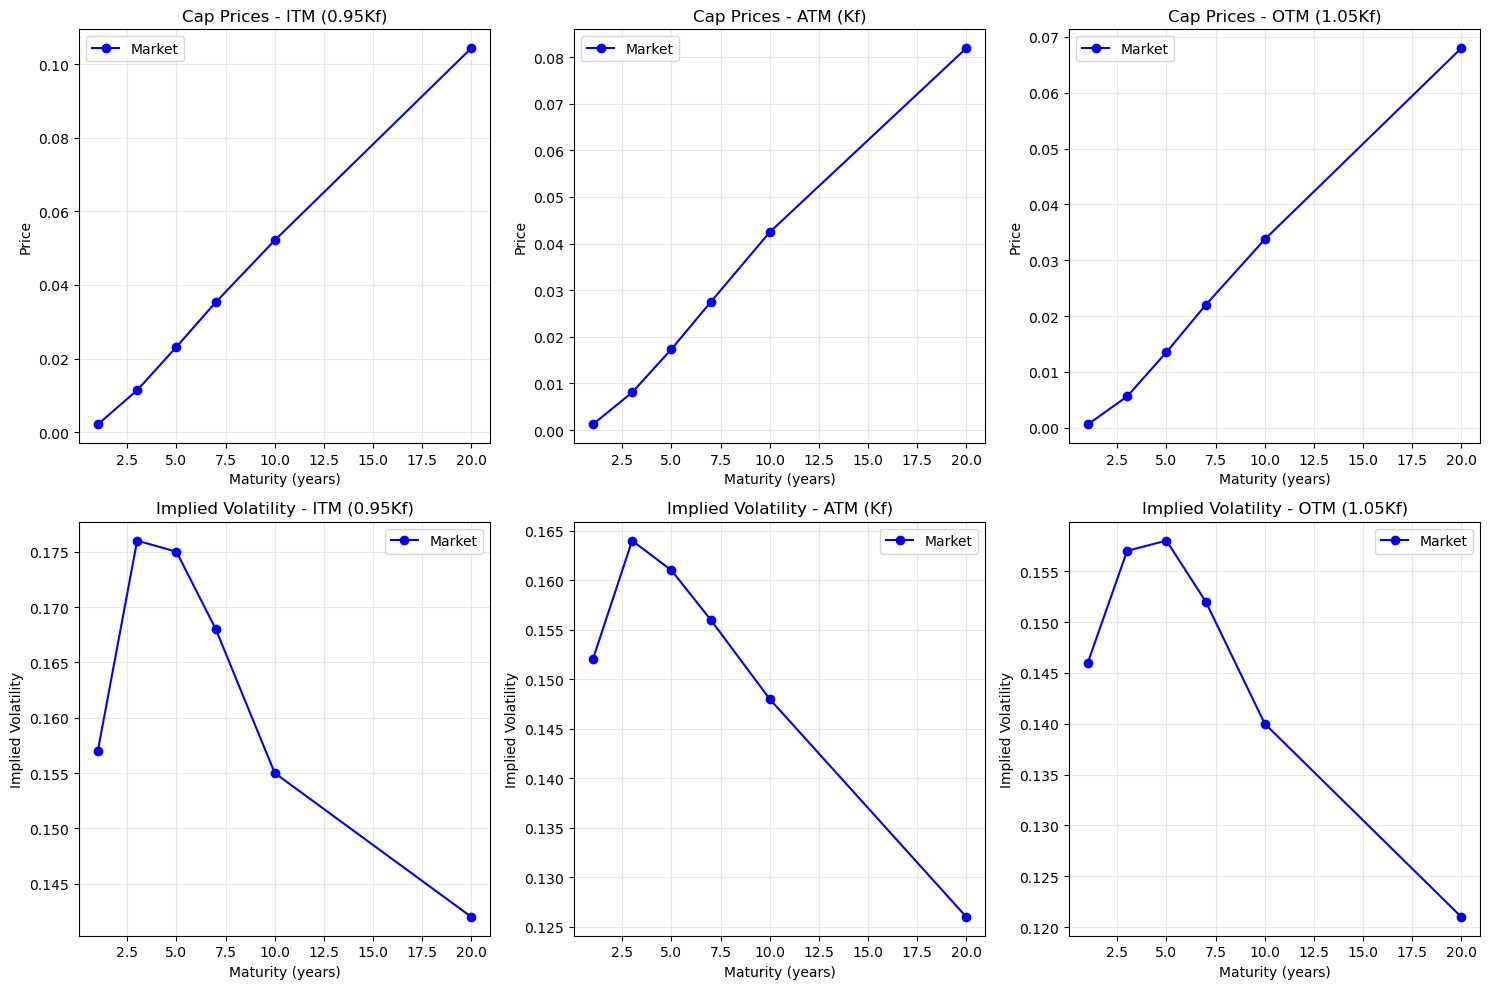

In [8]:
import matplotlib.pyplot as plt

# Extracting maturities
maturities = cap_mkt_prices_df["Maturity (years)"].values

# Extracting cap prices and implied volatilities for different strikes
cap_prices_market = {
    "0.95 K_f": cap_mkt_prices_df["0.95 K_f"].values,
    "K_f": cap_mkt_prices_df["K_f"].values,
    "1.05 K_f": cap_mkt_prices_df["1.05 K_f"].values,
}

implied_vol_market = {
    "0.95 K_f": sigmas["0.95 K_f"].values,
    "K_f": sigmas["K_f"].values,
    "1.05 K_f": sigmas["1.05 K_f"].values,
}

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

strikes = ["0.95 K_f", "K_f", "1.05 K_f"]
titles = ["ITM (0.95Kf)", "ATM (Kf)", "OTM (1.05Kf)"]

# First row: Cap Prices
for j in range(3):
    ax = axes[0, j]
    ax.plot(maturities, cap_prices_market[strikes[j]], "o-", label="Market", color="blue")
    ax.set_title(f"Cap Prices - {titles[j]}")
    ax.set_xlabel("Maturity (years)")
    ax.set_ylabel("Price")
    ax.grid(True, alpha=0.3)
    ax.legend()

# Second row: Implied Volatility
for j in range(3):
    ax = axes[1, j]
    ax.plot(maturities, implied_vol_market[strikes[j]], "o-", label="Market", color="blue")
    ax.set_title(f"Implied Volatility - {titles[j]}")
    ax.set_xlabel("Maturity (years)")
    ax.set_ylabel("Implied Volatility")
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()

In [9]:
# Brigo Mercurior Model

# Fix the random seed to ensure consistent results for each run
np.random.seed(42)  

def get_phi(kappa, theta, sigma, X0, gamma, t):
    """Calculate phi(0, t) = f_NSS(0,t) - f_CIR(0,t)"""

    # Calculate instantaneous forward rate for NSS
    f_NSS = instantaneous_forward_rate(t)

    # Calculate instantaneous forward rate for CIR
    term1 = (kappa + gamma) * (np.exp(gamma * t) - 1) + 2 * gamma
    f_CIR = (kappa * theta * (np.exp(gamma * t) - 1)) / term1 + \
            X0 * (4 * np.exp(gamma * t) * gamma**2) / term1**2

    return f_NSS - f_CIR

def calculate_bcir(t, T, kappa, gamma):
        """Calculate b_cir(t,T) based on the formula from notes"""
        num = 2 * gamma * np.exp(gamma*(T-t))
        denom = (kappa + gamma)*(np.exp(gamma*(T-t)) - 1) + 2*gamma
        return num/denom

def calculate_acir(t, T, kappa, theta, sigma, gamma):
        """Calculate A_cir(t,T) based on the formula from notes"""
        num = 2 * gamma * np.exp((kappa+gamma)*(T-t)/2)
        denom = (kappa + gamma)*(np.exp(gamma*(T-t)) - 1) + 2*gamma
        power = 2*kappa*theta/sigma**2
        return (num/denom)**power

# Monte Carlo simulation for CIR process
def simulate_BMpath(kappa, theta, sigma, X0, gamma, N, dt, n_paths):
    X = np.zeros((N, n_paths))
    r = np.zeros((N, n_paths))
    phi = np.zeros((N, n_paths))
    X[0, :] = 0
    phi [0, :] = 0 
    
    for i in range(1, N):
        dW = np.sqrt(dt) * np.random.randn(n_paths)  
        X[i, :] = X[i-1, :] + kappa * (theta - X[i-1, :]) * dt + sigma * np.sqrt(np.maximum(X[i-1, :], 0)) * dW
        phi[i, :] = get_phi(kappa, theta, sigma, X0, gamma, i * dt)
        r[i, :] = X[i, :] + phi[i, :]
    r[0, :] = r[1, :]
    return r, phi

In [10]:
# Compute discount factor paths
def compute_discount_factors(kappa, theta, sigma, X0, gamma, N, dt, n_paths, T, t_grid):
    
    # Run Monte Carlo simulation
    r_paths, phi = simulate_BMpath(kappa, theta, sigma, X0, gamma, N, dt, n_paths)  # 正确解包返回值

    # Generate an array of time points
    t_target = np.arange(0.25, T + 0.01, 0.25)  # [0.25, 0.5, ..., T]

    # Find the closest indices in t_grid corresponding to t_target
    indices = np.searchsorted(t_grid, t_target)

    # Ensure indices are within valid range
    indices = np.clip(indices, 0, len(t_grid) - 1) 

    # Extract corresponding r_values and phi_values at selected time points
    r_values = r_paths[indices, :]  # (len(t_target), n_paths)
    phi_values = phi[indices, :]  # (len(t_target), n_paths)

    n = len(t_target) - 1
    D = np.zeros((n, n_paths))  # P(t_j-1, tj)
    
    a_bm = np.zeros((n, n_paths))
    
    b_cir_0t = np.zeros((n, n_paths))
    b_cir_0T = np.zeros((n, n_paths))
    b_cir_tT = np.zeros((n, n_paths))
    
    a_cir_0t = np.zeros((n, n_paths))
    a_cir_0T = np.zeros((n, n_paths))
    a_cir_tT = np.zeros((n, n_paths))
    
    p_0t = np.zeros((n, n_paths))
    p_0T = np.zeros((n, n_paths))
    
    # Compute the discount factors 
    for i in range(0, len(t_target) - 1):
        t_prev = t_target[i]
        t = t_target[i+1]

        p_0t[i, :] = P(t_prev)
        p_0T[i, :] = P(t)

        b_cir_0t[i, :] = calculate_bcir(0, t_prev, kappa, gamma)
        b_cir_0T[i, :] = calculate_bcir(0, t, kappa, gamma)
        b_cir_tT[i, :] = calculate_bcir(t_prev, t, kappa, gamma)

        a_cir_0t[i, :] = calculate_acir(0, t_prev, kappa, theta, sigma, gamma)
        a_cir_0T[i, :] = calculate_acir(0, t, kappa, theta, sigma, gamma)
        a_cir_tT[i, :] = calculate_acir(t_prev, t, kappa, theta, sigma, gamma)

        a_bm [i, :] = (p_0T[i, :] * a_cir_0t[i, :] * np.exp( - b_cir_0t[i, :] * X0)) * (a_cir_tT[i, :] * np.exp (b_cir_tT[i, :] * phi_values[i])) / (p_0t[i, :] * a_cir_0T[i, :] * np.exp( - b_cir_0T[i, :] * X0))
        
        D[i, :] = a_bm [i, :] * np.exp(- b_cir_tT[i, :] * r_values[i+1])

    return D

In [11]:
def cap_price_bm(kappa, theta, sigma, X0, strike_rate, N, dt, n_paths, T, t_grid):

    gamma = np.sqrt(kappa**2 + 2*sigma**2)
    tau = 0.25
    M = 1
    
    # Calculate K' and M' according to formula
    K_prime = 1/(1 + strike_rate * tau)
    M_prime = M * (1 + strike_rate * tau)

    D = compute_discount_factors(kappa, theta, sigma, X0, gamma, N, dt, n_paths, T, t_grid)
    
    cap_price = 0  # Initialize Cap price
    
    for j in range(n_paths):  # Iterate over all Monte Carlo paths
        for i in range(len(D)):  # Iterate over all time steps   
            discount_factor = D[i, j]
            caplet_price = M_prime * max(K_prime - discount_factor, 0)  # Compute caplet price        
            cap_price += caplet_price

     # Compute final Cap price (Monte Carlo average)
    cap_price /= n_paths  # Take the average

    return cap_price

In [12]:
# Objective function (minimizing error)
def objective_function(params):
    """
    Computes the error between the model Cap price and the market Cap price.
    params: [kappa, theta, sigma, X0] (parameters to be calibrated)
    """

    total_error = 0
    kf_multipliers = [0.95, 1.0, 1.05]
    kappa, theta, sigma, X0 = params  # Unpack parameters

    for i, T in enumerate(T_values):
            for j, mult in enumerate(kf_multipliers):
                n_paths = 100
                N = 10 * T
                #N = 365 * T 
                dt = T / N
                t_grid = np.linspace(0, T, N)
                strike_rate = mult * Kf_values[T]
                
                model_price = cap_price_bm(kappa, theta, sigma, X0, strike_rate, N, dt, n_paths, T, t_grid)
                market_price = cap_mkt_prices_df.iloc[i, j+1]
                
                if market_price > 0:
                    relative_error = ((model_price - market_price) / market_price) ** 2
                    total_error += relative_error
                
    return total_error

In [13]:
initial_params = [2.5, 0.0008, 0.15, 0]  # [kappa, theta, sigma, x0]
bounds = [(1, 4), (0.0005, 0.002), (0.05, 0.3), (0.001, 0.03)]
        
result = minimize(objective_function, 
                    initial_params,
                    bounds=bounds,
                    method='L-BFGS-B')

In [14]:
optimal_params, min_error = result.x, result.fun
print("Calibrated Parameters:")
print("    Parameter     Value")
print(f"    θ (theta) {optimal_params[1]:.6f}")
print(f"    κ (kappa) {optimal_params[0]:.6f}")
print(f"    σ (sigma) {optimal_params[2]:.6f}")
print(f"    v0        {optimal_params[3]:.6f}")
print(f"Objective Value {min_error:.6f}\n")

Calibrated Parameters:
    Parameter     Value
    θ (theta) 0.000800
    κ (kappa) 2.500003
    σ (sigma) 0.150000
    v0        0.001000
Objective Value 5.026166



In [15]:
# Create a DataFrame with the same structure as `cap_mkt_prices_df`
cap_model_prices_df = pd.DataFrame(index=T_values, columns=["0.95 K_f", "K_f", "1.05 K_f"])
kf_multipliers = [0.95, 1.0, 1.05]
estimated_kappa, estimated_theta, estimated_sigma, estimated_X0 = optimal_params

# Compute model Cap prices and populate `cap_model_prices_df`
for i, T in enumerate(T_values):
    for j, mult in enumerate(kf_multipliers):
        n_paths = 100  # Number of Monte Carlo paths
        N = 10 * T   # Number of time steps
        dt = T / N  # Time step size
        t_grid = np.linspace(0, T, N)  # Time grid
        strike_rate = mult * Kf_values[T]   # Compute strike rate

        # Compute model Cap price
        model_price = cap_price_bm(estimated_kappa, estimated_theta, estimated_sigma, estimated_X0,
                                   strike_rate, N, dt, n_paths, T, t_grid)

        # Store in DataFrame
        cap_model_prices_df.iloc[i, j] = model_price

# Add `Maturity (years)` column
cap_model_prices_df.insert(0, "Maturity (years)", T_values)

In [16]:
from scipy.optimize import brentq

def objective(sigma, tn, K, cap_sum_market):
    """Return the difference between the cap_model_price and the market observed cap price."""
    return cap_mkt_price(tn, K, sigma) - cap_sum_market
    
# Ensure strikes DataFrame is correctly formatted
strikes = pd.DataFrame(strike_matrix)
T_values = [1, 3, 5, 7, 10, 20]
model_iv_df = pd.DataFrame(index=strikes.index, columns=strikes.columns[1:])  # Exclude "Maturity (years)"

for i in range(strikes.shape[0]):  # i = 0..5
    tn = strikes.iloc[i, 0]       # Get the maturity (e.g., 1, 3, 5, 7, 10, 20)

    for j in range(1, strikes.shape[1]):  # j = 1..3

        K = strikes.iloc[i, j]           # Get the strike price from row i, column j of strikes
        model_price = cap_model_prices_df.iloc[i, j]

        implied_vol = brentq(objective, 0.0001, 1.0, args=(tn, K, model_price))
        model_iv_df.iloc[i, j - 1] = implied_vol
# Finally, insert the "Maturity (years)" column at the beginning
model_iv_df.insert(0, "Maturity (years)", strikes["Maturity (years)"])

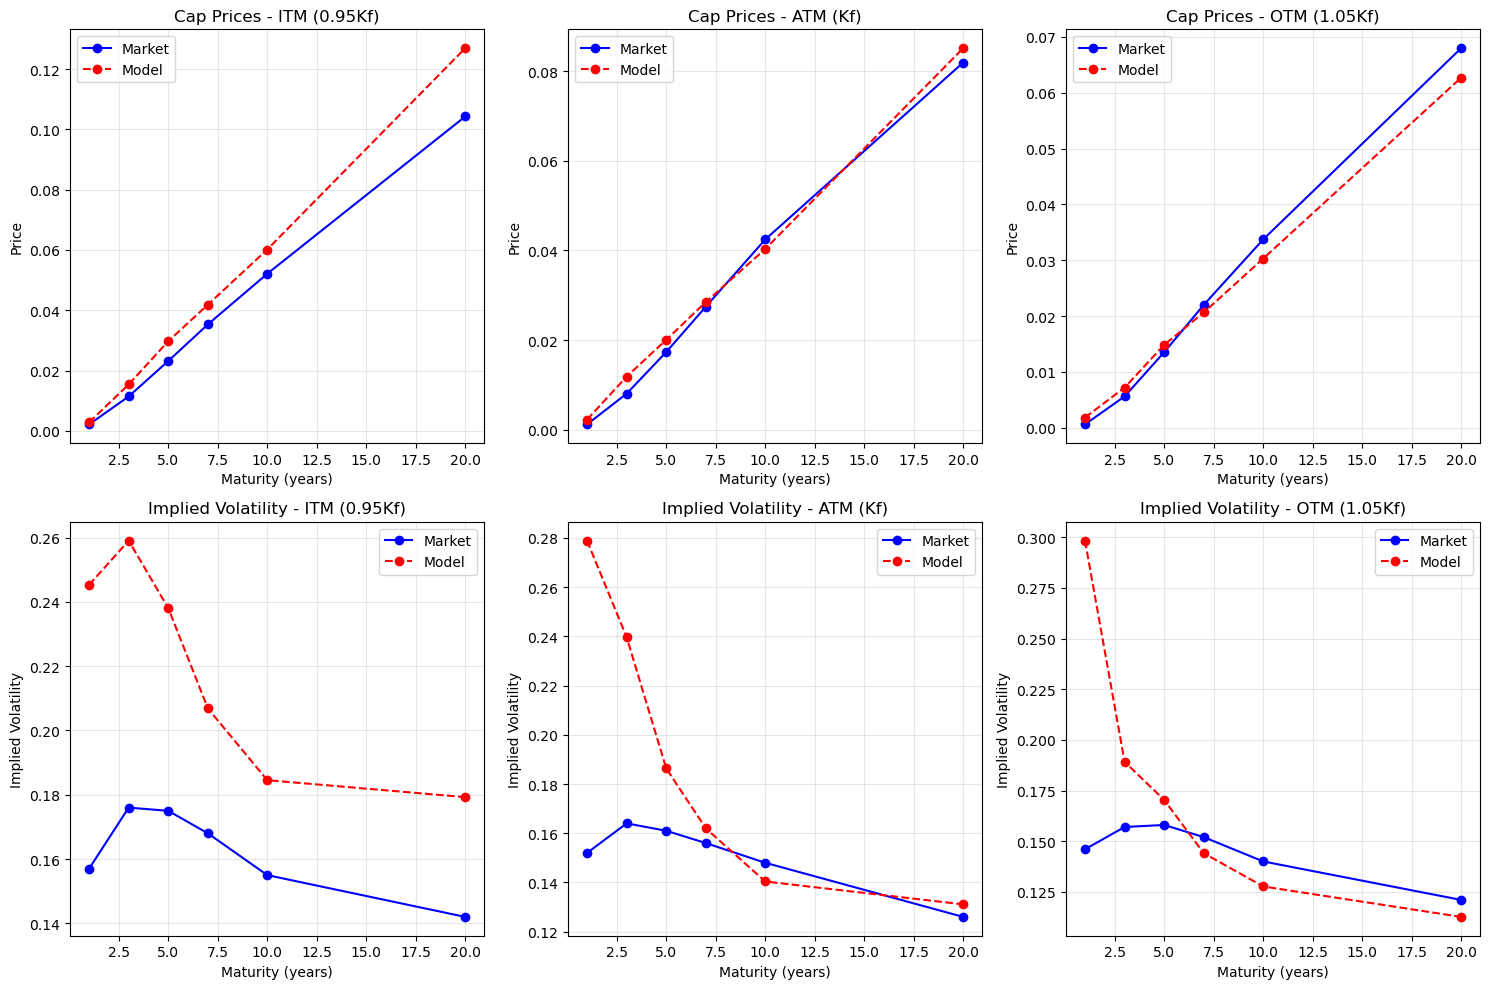

In [17]:
import matplotlib.pyplot as plt

# Extract maturities from the DataFrame
maturities = cap_mkt_prices_df["Maturity (years)"].values

# Extract cap market prices for different strikes
cap_prices_market = {
    "0.95 K_f": cap_mkt_prices_df["0.95 K_f"].values,
    "K_f": cap_mkt_prices_df["K_f"].values,
    "1.05 K_f": cap_mkt_prices_df["1.05 K_f"].values,
}

# Extract Model Prices for comparison
cap_prices_model = {
    "0.95 K_f": cap_model_prices_df["0.95 K_f"].values,
    "K_f": cap_model_prices_df["K_f"].values,
    "1.05 K_f": cap_model_prices_df["1.05 K_f"].values,
}

# Extract market implied volatilities
implied_vol_market = {
    "0.95 K_f": sigmas["0.95 K_f"].values,
    "K_f": sigmas["K_f"].values,
    "1.05 K_f": sigmas["1.05 K_f"].values,
}

# Extract Model Implied Volatilities for comparison
implied_vol_model = {
    "0.95 K_f": model_iv_df["0.95 K_f"].values,
    "K_f": model_iv_df["K_f"].values,
    "1.05 K_f": model_iv_df["1.05 K_f"].values,
}

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

strikes = ["0.95 K_f", "K_f", "1.05 K_f"]
titles = ["ITM (0.95Kf)", "ATM (Kf)", "OTM (1.05Kf)"]

# First row: Cap Prices (including Model Price)
for j in range(3):
    ax = axes[0, j]
    
     # Plot Market Price (blue solid line)
    ax.plot(maturities, cap_prices_market[strikes[j]], "o-", label="Market", color="blue")
    
    # Plot Model Price (red dashed line)
    ax.plot(maturities, cap_prices_model[strikes[j]], "o--", label="Model", color="red")
    
    ax.set_title(f"Cap Prices - {titles[j]}")
    ax.set_xlabel("Maturity (years)")
    ax.set_ylabel("Price")
    ax.grid(True, alpha=0.3)
    ax.legend()

# Second row: Implied Volatility
for j in range(3):
    ax = axes[1, j]
    # Plot Market Implied Volatilities (blue solid line)
    ax.plot(maturities, implied_vol_market[strikes[j]], "o-", label="Market", color="blue")
    # Plot Model Implied Volatilities (red dashed line)
    ax.plot(maturities, implied_vol_model[strikes[j]], "o--", label="Model", color="red")
    ax.set_title(f"Implied Volatility - {titles[j]}")
    ax.set_xlabel("Maturity (years)")
    ax.set_ylabel("Implied Volatility")
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()